In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from model_generation import generate_model

model = generate_model()
model3 = generate_model(noise=True)

C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
weights = model.get_weights()
thresh = np.percentile(np.abs(weights[-2]), 20)
weights[-2][np.abs(weights[-2])<thresh] = 0.0
config = model.get_config()
from keras.models import Sequential
model2 = Sequential.from_config(config)
model2.set_weights(weights)
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
from model_generation import generate_data
X_train, X_test, Y_train, Y_test = generate_data()
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)
score = model2.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.027638991620726572, 0.9917]
[0.026397230025109547, 0.9921]
[0.027638991620726572, 0.9917]
[0.026397230025109547, 0.9921]


In [4]:
X_train_noise, X_test_noise, Y_train, Y_test = generate_data(noise=True)
score = model.evaluate(X_test_noise, Y_test, verbose=0)
print(score)
score = model3.evaluate(X_test_noise, Y_test, verbose=0)
print(score)

NameError: name 'X_test_noise' is not defined

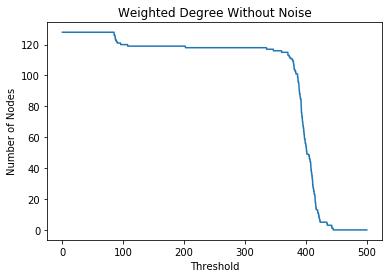

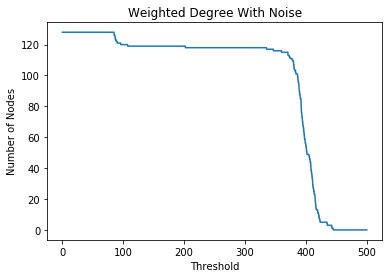

In [7]:
# function counting the number of nodes above a threshold
def thresh_count(arr, thresh):
    return(np.sum(arr > thresh))


def plot_l1_norm(model, title=""):
    # get the dense layer
    dense_layer= model.layers[-3]

    # pull out the weights
    dense_weights = np.array(dense_layer.get_weights())

    # compute the L1 norm for the dense weights
    dense_L1 = np.sum(np.abs(dense_weights[0]), axis = 0)

    # list of thresholds
    thresh_list = np.linspace(0,500, 2000)

    # count the number of nodes for all thresholds
    dense_count = np.array([thresh_count(dense_L1, thresh) for thresh in thresh_list])

    # plot count vs. thresh
    plt.plot(thresh_list, dense_count)
    plt.xlabel("Threshold")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    plt.show()
    
plot_l1_norm(model, title="Weighted Degree Without Noise")
plot_l1_norm(model3, title="Weighted Degree With Noise")

In [2]:
weights = np.abs(np.array(model.layers[-1].get_weights()[0]))
print(weights.shape)
weight_adj_matrix = np.zeros([sum(weights.shape),sum(weights.shape)])
weight_adj_matrix[weights.shape[0]:,:weights.shape[0]] = np.transpose(weights)


(128, 10)


In [27]:
import bct
bct.betweenness_wei(weight_adj_matrix)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [3]:
def weighted_clustering_coeff(G):
    """ Calculates clustering coefficient for a weighted network represented by an adjacency matrix """
    # https://www.researchgate.net/publication/49721057_Competition_for_Popularity_in_Bipartite_Networks
    k = G.shape[0] # assume fully connected
    coeffs = np.zeros((k,))
    for i in range(k):
        for j in range(k):
            for h in range(k):
                coeffs[i] += (G[i,j]*G[i,h]*G[h,j])**(1.0/3.0)
        Gv = np.max(G[i,:])
        coeffs[i] *= 2.0/(k*(k-1)*Gv)
    return coeffs

def calc_clustering_coeff_square(weights):
    """ Calculates clustering coefficients for a bipartite weighted network represented by a weight matrix """
    # Compute the unipartite networks correspondign to the bipartite network
    adj1 = np.matmul(weights, np.transpose(weights))
    adj2 = np.matmul(np.transpose(weights), weights)
    return weighted_clustering_coeff(adj1), weighted_clustering_coeff(adj2)

coeffs1, coeffs2 = calc_clustering_coeff_square(weights)

print(coeffs1)
print(coeffs2)

[1.34057611 1.50929653 1.73605064 1.19731262 1.21102299 1.14816974
 1.34676438 1.32896723 1.11015616 1.32267434 1.24690514 1.37216327
 1.2618905  1.58620752 1.36436365 1.25307896 1.0651853  1.34867898
 1.3329485  1.19433681 1.33923586 1.20956296 1.14357654 1.15410609
 1.24276211 1.40917349 1.16005138 1.26479179 1.12942346 1.31852542
 1.34208809 1.10928271 1.34256744 1.19474112 1.09693357 1.21969238
 1.33213253 1.16233619 1.35825865 0.99936869 1.411696   1.07375474
 1.33125376 1.16354931 1.58182676 1.0077414  1.25371257 1.07120339
 0.96135188 1.15632041 1.16282898 1.21361514 1.13190723 1.28605185
 1.32902381 1.29287965 1.19192672 1.07087063 1.36577335 1.3291784
 1.21573007 1.20185324 1.07382408 1.36950737 1.30892518 1.25571976
 1.1071466  1.24970833 1.1947265  1.2443683  1.1305623  1.20260526
 1.10690225 1.21118867 1.18741045 1.15627933 1.18112905 1.24582391
 1.44560972 1.13710016 1.42113953 1.12928808 1.40018532 1.44986259
 1.35788285 1.08306589 1.09742208 1.06305242 1.35042668 0.95475

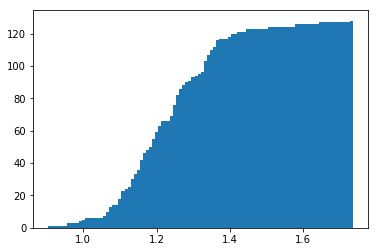

In [5]:
coeffs1, coeffs2 = calc_clustering_coeff_square(weights)
plt.hist(coeffs1, bins=100, cumulative=True)
plt.show()
# coeffs1, coeffs2 = calc_clustering_coeff_square(weights_noise)
# plt.hist(coeffs1, bins=100, cumulative=True)
# plt.show()

In [3]:
# Compute the adjacency matrix of the layer
layer_adj_matrix = np.matmul(weights, np.transpose(weights))
print(layer_adj_matrix)

[[0.48281583 0.13003856 0.12423163 ... 0.36131796 0.43616673 0.31289464]
 [0.13003856 0.10315547 0.06657131 ... 0.1340848  0.20803358 0.14207378]
 [0.12423163 0.06657131 0.0603534  ... 0.10946285 0.1740945  0.11754135]
 ...
 [0.36131796 0.1340848  0.10946285 ... 0.33651704 0.38376465 0.2618209 ]
 [0.43616673 0.20803358 0.1740945  ... 0.38376465 0.59713423 0.39562884]
 [0.31289464 0.14207378 0.11754135 ... 0.2618209  0.39562884 0.3243383 ]]


In [4]:
# Find the highest activation image for each node in the first dense layer
from model_generation import generate_data
X_train, Y_train, X_test, Y_test = generate_data()

inp = model.input                                           # input placeholder
outputs = [model.layers[-3].output]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
test = X_test[:1000]
layer_outs = functor([test, 1.])
print(layer_outs[0].shape)
print(layer_outs[0])
repr_indices = np.argmax(layer_outs[0], axis=0)
# print(np.argmax(layer_outs[0],axis=1))

(1000, 128)
[[0.14946799 0.         0.         ... 0.         1.8594362  0.        ]
 [2.9652686  0.         0.         ... 5.627422   5.6663914  6.2540345 ]
 [3.3109639  0.         0.         ... 0.         2.3872674  1.1143736 ]
 ...
 [0.         0.         0.         ... 0.2063659  0.         0.        ]
 [0.         0.         0.         ... 3.6705825  0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [5]:
from matplotlib import pyplot as plt
for i in range(10):
    plt.imshow(X_test[i][0], cmap="binary")
    plt.show()

In [6]:
print(repr_indices)
print(len(repr_indices))

[891   0   0 763 384 281 164 631 128 638 522 841 425   0   0 363  22 299
 841 477 845 631 721 110 841  11 860 876 860 216 912 990 299 536 626 876
 565 665   0 890 997 912 147 694   0 966 864 569  75 568 482 997 841 904
 612 980 245 536 458 722 837 211 596 486 390 164 522 602 546 384 625 597
 503 997  13 250  63 433   0 807  82 284 720 493 711 103 458 813   0 822
 349 123 658 806 787 581 779 503 822  82 333 996  97 453  56 327 514 654
   0 156 163 516 367 326  54 810 819 698 860 792 890 560 466 636 703 318
 837 472]
128


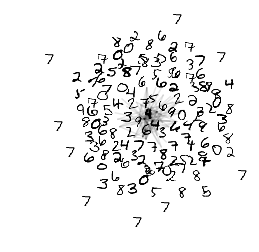

In [21]:
import networkx as nx
from networkx.drawing import spring_layout
#G = nx.Graph(layer_adj_matrix)
G = nx.Graph(layer_adj_matrix, width=layer_adj_matrix)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40)
layout = spring_layout(G)

fig = plt.Figure()
# Generate the image
for i in range(128):
    for j in range(128):
        if layer_adj_matrix[i,j]>0.6:
            pos1 = layout[i]*100
            pos2 = layout[j]*100
            plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], alpha=0.05, color="black")
        
for i in range(128):
    pos = layout[i]*200
    extent = [pos[0]-14, pos[0]+14, pos[1]-14, pos[1]+14]
    img = X_test[repr_indices[i]][0].copy()
#     # add a black border
#     for i in range(len(img)):
#         img[i][0] = 1
#         img[i][-1] = 1
#         for j in range(len(img[0])):
#             img[0][j] = 1
#             img[-1][j] = 1
    img = np.ma.masked_where(img == 0, img)
    plt.imshow(img, interpolation="nearest", extent=extent, cmap="binary")
plt.autoscale()
plt.axis("off")
plt.show()